In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50, VGG19, MobileNet, DenseNet121, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


In [ ]:
#!pip install efficientnet

In [ ]:
import efficientnet.keras as efn
import tensorflow as tf

In [ ]:
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn import metrics

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        #_, ftype = os.path.splitext(PATH)
#         if ftype == ".jpg":
        img = read(PATH)
           
        img = cv2.resize(img, (RESIZE,RESIZE))
           
        IMG.append(np.array(img))
    return IMG

In [ ]:
covid_train = np.array(Dataset_loader('../COVID-19_DETECTION/COVID-SET/train/COVID-19',224))
non_covid_train = np.array(Dataset_loader('../COVID-19_DETECTION/COVID-SET/train/NON-COVID-19',224))

100%|████████████████████████████████████████████████████████████████████████████████| 433/433 [00:08<00:00, 48.97it/s]


In [ ]:
covid_test = np.array(Dataset_loader('../COVID-19_DETECTION/COVID-SET/val/COVID-19',224))
non_covid_test = np.array(Dataset_loader('../COVID-19_DETECTION/COVID-SET/val/NON-COVID-19',224))

100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [00:02<00:00, 49.09it/s]


In [ ]:
covid_train_label = np.zeros(len(covid_train))
non_covid_train_label = np.ones(len(non_covid_train))

In [ ]:
covid_test_label = np.zeros(len(covid_test))
non_covid_test_label = np.ones(len(non_covid_test))

In [ ]:
X_train = np.concatenate((covid_train, non_covid_train), axis = 0)
Y_train = np.concatenate((covid_train_label, non_covid_train_label), axis = 0)

In [ ]:
X_test = np.concatenate((covid_test, non_covid_test), axis = 0)
Y_test = np.concatenate((covid_test_label, non_covid_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= None, dtype ="uint8")
#print(Y_train)
Y_test = to_categorical(Y_test, num_classes= None, dtype ="uint8")

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [ ]:
BATCH_SIZE = 10

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape= (224,224,3))

In [ ]:
base_model.summary()
model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 4,057,246
Trainable params: 4,012,670
Non-trainable params: 44,576
_________________________________________________________________


In [ ]:
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=1e-4),
        metrics=['accuracy']
    )

In [ ]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001C39C8F7B20>>

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="covid.detect.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=150,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\ATHIRANIRMAL\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
66/66 [==============================] - 285s 4s/step - loss: 0.8677 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.5774

Epoch 00001: val_accuracy improved from -inf to 0.57738, saving model to covid.detect.hdf5
Epoch 2/150
66/66 [==============================] - 300s 4s/step - loss: 0.7975 - accuracy: 0.5303 - val_loss: 0.5746 - val_accuracy: 0.7083

Epoch 00002: val_accuracy improved from 0.57738 to 0.70833, saving model to covid.detect.hdf5
Epoch 3/150
66/66 [==============================] - 276s 4s/step - loss: 0.7196 - accuracy: 0.6222 - val_loss: 0.5257 - val_accuracy: 0.7560

Epoch 00003: val_accuracy improved from 0.70833 to 0.75595, saving model to covid.detect.hdf5
Epoch 4/150
66/66 [==============================] - 282s 4s/step - loss: 0.6905 - accuracy: 0.6422 - val_loss: 0.5523 - val_accuracy: 0.7083

Epoch 00004: val_accuracy did not improve from 0.75595
Epoch 5/150
66/66 [==============================] - 265s 4s/step - loss: 0.6155 - accuracy: 0

66/66 [==============================] - 269s 4s/step - loss: 0.6026 - accuracy: 0.6985 - val_loss: 0.4155 - val_accuracy: 0.8214

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 00039: val_accuracy did not improve from 0.83333
Epoch 40/150
66/66 [==============================] - 269s 4s/step - loss: 0.5416 - accuracy: 0.7377 - val_loss: 0.4140 - val_accuracy: 0.8214

Epoch 00040: val_accuracy did not improve from 0.83333
Epoch 41/150
66/66 [==============================] - 271s 4s/step - loss: 0.5361 - accuracy: 0.7698 - val_loss: 0.4180 - val_accuracy: 0.8214

Epoch 00041: val_accuracy did not improve from 0.83333
Epoch 42/150
66/66 [==============================] - 271s 4s/step - loss: 0.6042 - accuracy: 0.7159 - val_loss: 0.4133 - val_accuracy: 0.8333

Epoch 00042: val_accuracy did not improve from 0.83333
Epoch 43/150
66/66 [==============================] - 274s 4s/step - loss: 0.5779 - accuracy: 0.7418 - val_loss: 0.4136 - val_accuracy: 0.8095

Epoch 00


Epoch 00077: val_accuracy did not improve from 0.83333
Epoch 78/150
66/66 [==============================] - 271s 4s/step - loss: 0.5496 - accuracy: 0.7421 - val_loss: 0.4078 - val_accuracy: 0.8333

Epoch 00078: val_accuracy did not improve from 0.83333
Epoch 79/150
66/66 [==============================] - 287s 4s/step - loss: 0.5520 - accuracy: 0.7437 - val_loss: 0.4108 - val_accuracy: 0.8214

Epoch 00079: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 00079: val_accuracy did not improve from 0.83333
Epoch 80/150
66/66 [==============================] - 268s 4s/step - loss: 0.5628 - accuracy: 0.7314 - val_loss: 0.4143 - val_accuracy: 0.8155

Epoch 00080: val_accuracy did not improve from 0.83333
Epoch 81/150
66/66 [==============================] - 270s 4s/step - loss: 0.5571 - accuracy: 0.7318 - val_loss: 0.4177 - val_accuracy: 0.8214

Epoch 00081: val_accuracy did not improve from 0.83333
Epoch 82/150
66/66 [==============================] - 271s 4s/step - loss: 0.5785 -

66/66 [==============================] - 267s 4s/step - loss: 0.5445 - accuracy: 0.7227 - val_loss: 0.4119 - val_accuracy: 0.8333

Epoch 00116: val_accuracy did not improve from 0.83333
Epoch 117/150
66/66 [==============================] - 283s 4s/step - loss: 0.5999 - accuracy: 0.7311 - val_loss: 0.4139 - val_accuracy: 0.8274

Epoch 00117: val_accuracy did not improve from 0.83333
Epoch 118/150
66/66 [==============================] - 265s 4s/step - loss: 0.5886 - accuracy: 0.7340 - val_loss: 0.4175 - val_accuracy: 0.8155

Epoch 00118: val_accuracy did not improve from 0.83333
Epoch 119/150
66/66 [==============================] - 290s 4s/step - loss: 0.5477 - accuracy: 0.7169 - val_loss: 0.4130 - val_accuracy: 0.8214

Epoch 00119: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 00119: val_accuracy did not improve from 0.83333
Epoch 120/150
66/66 [==============================] - 277s 4s/step - loss: 0.5609 - accuracy: 0.7352 - val_loss: 0.4133 - val_accuracy: 0.8155

Epoc

<AxesSubplot:>

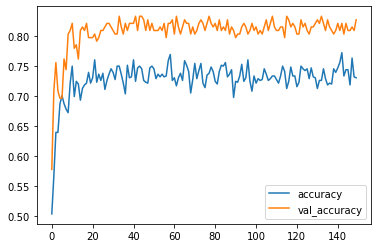

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
model.load_weights("covid.detect.hdf5")

In [ ]:
Y_val_pred = model.predict(x_val)

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8333333333333334

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\ATHIRANIRMAL\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:25<00:00, 20.52s/it]


In [ ]:
# from keras.models import load_model
# model = load_model("covid.detect.hdf5")

In [ ]:
# Y_val_pred = model.predict(x_val)

In [ ]:
# accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

Confusion matrix, without normalization
[[82 19]
 [19 90]]


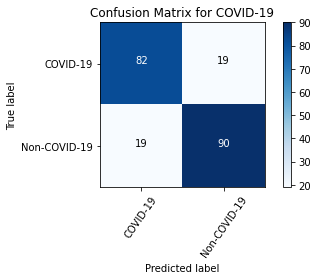

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['COVID-19', 'Non-COVID-19']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for COVID-19')